In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

<h3>VARIABLES</h3>

In [2]:
IMG_SHAPE = (300,300,3)
LR = 0.003
EPOCHS = 10
BATCH_SIZE=21

<h3>Load Data</h3>

In [3]:
(ds_train, ds_test)= tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    batch_size=BATCH_SIZE
    
)


In [4]:
# Augment data

ds_train = ds_train.map(
    lambda image, label: ((image / 127 -  1), label)
).map(
    lambda image, label: (tf.image.random_flip_left_right(image), label)
).map(
    lambda image, label: (tf.image.random_flip_up_down(image), label)
).map(
    lambda image, label: (tf.image.random_contrast(image, lower=0.0, upper=1.0), label)
)

ds_test = ds_test.map(
    lambda image, label: ((image / 127 -  1), label)
)

<h3>Model Setup</h3>

In [5]:
# MobileNet bottom layers with ImageNet weights

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False



In [6]:
# Create Model

inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs) <-- Layers don't exist in Tensorflow.js
# x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs) # Rescale inputs to [-1,1] from 0-255
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)


In [7]:
# Callback

class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > .99):
            self.model.stop_training = True

callback = Callback()

In [8]:
# Compile model

model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 2,915,395
Trainable params: 657,411
Non-trainable params: 2,257,984
______________________________________

<h3>Fit data and Plot results</h3>

In [10]:
history = model.fit(ds_train,
                    validation_data=ds_test,
                    epochs=EPOCHS,
                    callbacks=[callback])

Epoch 1/10
120/120 [==============================] - 111s 924ms/step - loss: 0.4574 - accuracy: 0.8635 - val_loss: 0.3865 - val_accuracy: 0.8468
Epoch 2/10
120/120 [==============================] - 113s 940ms/step - loss: 0.1401 - accuracy: 0.9567 - val_loss: 0.5019 - val_accuracy: 0.8629
Epoch 3/10
120/120 [==============================] - 110s 916ms/step - loss: 0.0955 - accuracy: 0.9639 - val_loss: 0.6827 - val_accuracy: 0.7930
Epoch 4/10
120/120 [==============================] - 111s 924ms/step - loss: 0.0779 - accuracy: 0.9742 - val_loss: 0.4353 - val_accuracy: 0.8253
Epoch 5/10
120/120 [==============================] - 111s 925ms/step - loss: 0.1578 - accuracy: 0.9647 - val_loss: 0.3740 - val_accuracy: 0.8360
Epoch 6/10
120/120 [==============================] - 111s 926ms/step - loss: 0.0646 - accuracy: 0.9837 - val_loss: 0.4476 - val_accuracy: 0.8226
Epoch 7/10
120/120 [==============================] - 112s 931ms/step - loss: 0.0851 - accuracy: 0.9750 - val_loss: 0.4111 -

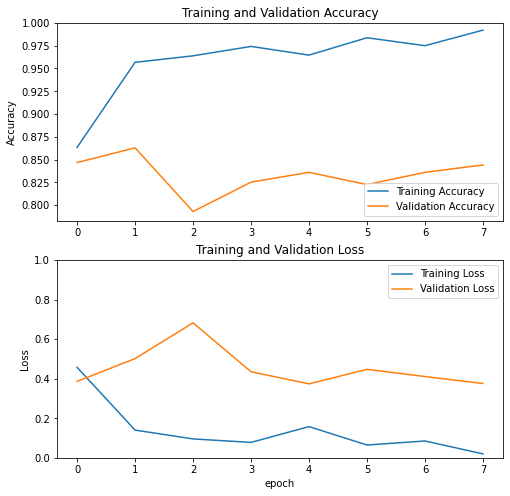

In [13]:
# Plot Loss and Accuracy for Taining and Validation data

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<h3>Save Model</h3>

In [14]:
# Path to directory
path = './public/model/'
model_path = path + 'model.h5'

# Save Model
model.save(model_path)

# Convert for Tensorflow.js
!tensorflowjs_converter --input_format=keras {model_path} {path}